<a href="https://colab.research.google.com/github/derektypist/boilerplate-neural-network-sms-text-classifier/blob/master/Copy_of_fcc_sms_text_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*Note: You are currently reading this using Google Colaboratory which is a cloud-hosted version of Jupyter Notebook. This is a document containing both text cells for documentation and runnable code cells. If you are unfamiliar with Jupyter Notebook, watch this 3-minute introduction before starting this challenge: https://www.youtube.com/watch?v=inN8seMm7UI*

---

In this challenge, you need to create a machine learning model that will classify SMS messages as either "ham" or "spam". A "ham" message is a normal message sent by a friend. A "spam" message is an advertisement or a message sent by a company.

You should create a function called `predict_message` that takes a message string as an argument and returns a list. The first element in the list should be a number between zero and one that indicates the likeliness of "ham" (0) or "spam" (1). The second element in the list should be the word "ham" or "spam", depending on which is most likely.

For this challenge, you will use the [SMS Spam Collection dataset](http://www.dt.fee.unicamp.br/~tiago/smsspamcollection/). The dataset has already been grouped into train data and test data.

The first two cells import the libraries and data. The final cell tests your model and function. Add your code in between these cells.


In [355]:
# import libraries
try:
  # %tensorflow_version only exists in Colab.
  !pip install tf-nightly
except Exception:
  pass
import tensorflow as tf
import pandas as pd
from tensorflow import keras
!pip install tensorflow-datasets
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

2.6.0-dev20210612


In [356]:
# get data files
!wget https://cdn.freecodecamp.org/project-data/sms/train-data.tsv
!wget https://cdn.freecodecamp.org/project-data/sms/valid-data.tsv

train_file_path = "train-data.tsv"
test_file_path = "valid-data.tsv"

--2021-06-12 12:42:32--  https://cdn.freecodecamp.org/project-data/sms/train-data.tsv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 104.26.3.33, 104.26.2.33, 172.67.70.149, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|104.26.3.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 358233 (350K) [text/tab-separated-values]
Saving to: ‘train-data.tsv.17’

train-data.tsv.17   100%[===================>] 349.84K  --.-KB/s    in 0.004s  

2021-06-12 12:42:32 (90.0 MB/s) - ‘train-data.tsv.17’ saved [358233/358233]

--2021-06-12 12:42:32--  https://cdn.freecodecamp.org/project-data/sms/valid-data.tsv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 104.26.3.33, 104.26.2.33, 172.67.70.149, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|104.26.3.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 118774 (116K) [text/tab-separated-values]
Saving to: ‘valid-data.tsv.17’

valid-data.tsv.17   100%[=====

In [357]:
train_file_path, test_file_path

('train-data.tsv', 'valid-data.tsv')

In [358]:
# Read the data
df_train = pd.read_csv(train_file_path, sep='\t', header=None, names=['type','message'])
df_train.tail()

,type,message
4174,ham,just woke up. yeesh its late. but i didn't fal...
4175,ham,what do u reckon as need 2 arrange transport i...
4176,spam,free entry into our £250 weekly competition ju...
4177,spam,-pls stop bootydelious (32/f) is inviting you ...
4178,ham,tell my bad character which u dnt lik in me. ...


In [359]:
df_test = pd.read_csv(test_file_path, sep='\t', header=None, names=['type','message'])
df_test.tail()

,type,message
1387,ham,true dear..i sat to pray evening and felt so.s...
1388,ham,"what will we do in the shower, baby?"
1389,ham,where are you ? what are you doing ? are yuou ...
1390,spam,ur cash-balance is currently 500 pounds - to m...
1391,spam,not heard from u4 a while. call 4 rude chat pr...


In [360]:
df_train.describe, df_test.describe

(<bound method NDFrame.describe of       type                                            message
 0      ham  ahhhh...just woken up!had a bad dream about u ...
 1      ham                           you can never do nothing
 2      ham  now u sound like manky scouse boy steve,like! ...
 3      ham  mum say we wan to go then go... then she can s...
 4      ham  never y lei... i v lazy... got wat? dat day ü ...
 ...    ...                                                ...
 4174   ham  just woke up. yeesh its late. but i didn't fal...
 4175   ham  what do u reckon as need 2 arrange transport i...
 4176  spam  free entry into our £250 weekly competition ju...
 4177  spam  -pls stop bootydelious (32/f) is inviting you ...
 4178   ham  tell my  bad character which u dnt lik in me. ...
 
 [4179 rows x 2 columns]>,
 <bound method NDFrame.describe of       type                                            message
 0      ham  i am in hospital da. . i will return home in e...
 1      ham         n

In [361]:
# Categorize the data
# ham - 0, spam - 1
type_train = df_train['type'].astype('category').cat.codes
type_test = df_test['type'].astype('category').cat.codes
type_train, type_test


(0       0
 1       0
 2       0
 3       0
 4       0
        ..
 4174    0
 4175    0
 4176    1
 4177    1
 4178    0
 Length: 4179, dtype: int8, 0       0
 1       0
 2       0
 3       0
 4       0
        ..
 1387    0
 1388    0
 1389    0
 1390    1
 1391    1
 Length: 1392, dtype: int8)

Text(0.5, 0, 'sms')

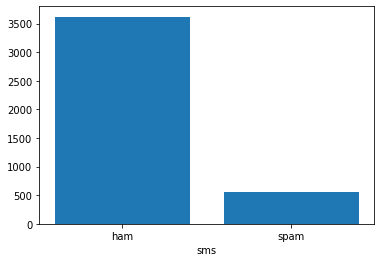

In [362]:
# Plot Histogram
bar = df_train['type'].value_counts()
plt.bar(bar.index,bar)
plt.xlabel('sms')

In [363]:
# Apply Preprocessing
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

import re
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [364]:
# Remove stop words
stop_words = set(stopwords.words('english'))
len(stop_words),stop_words

(179,
 {'a',
  'about',
  'above',
  'after',
  'again',
  'against',
  'ain',
  'all',
  'am',
  'an',
  'and',
  'any',
  'are',
  'aren',
  "aren't",
  'as',
  'at',
  'be',
  'because',
  'been',
  'before',
  'being',
  'below',
  'between',
  'both',
  'but',
  'by',
  'can',
  'couldn',
  "couldn't",
  'd',
  'did',
  'didn',
  "didn't",
  'do',
  'does',
  'doesn',
  "doesn't",
  'doing',
  'don',
  "don't",
  'down',
  'during',
  'each',
  'few',
  'for',
  'from',
  'further',
  'had',
  'hadn',
  "hadn't",
  'has',
  'hasn',
  "hasn't",
  'have',
  'haven',
  "haven't",
  'having',
  'he',
  'her',
  'here',
  'hers',
  'herself',
  'him',
  'himself',
  'his',
  'how',
  'i',
  'if',
  'in',
  'into',
  'is',
  'isn',
  "isn't",
  'it',
  "it's",
  'its',
  'itself',
  'just',
  'll',
  'm',
  'ma',
  'me',
  'mightn',
  "mightn't",
  'more',
  'most',
  'mustn',
  "mustn't",
  'my',
  'myself',
  'needn',
  "needn't",
  'no',
  'nor',
  'not',
  'now',
  'o',
  'of',
  'o

In [365]:
# Get a valid root word
lemmatizer = WordNetLemmatizer()
def word_lemmatizer(msg):
  txt = re.sub(r'([^\s\w])+', ' ',msg)
  txt = " ".join([lemmatizer.lemmatize(word) for word in txt.split() if not word in stop_words])
  txt = txt.lower()
  return txt

In [366]:
message_train = df_train['message'].apply(lambda x:word_lemmatizer(x))
message_train

0       ahhhh woken bad dream u tho dont like u right ...
1                                           never nothing
2       u sound like manky scouse boy steve like trave...
3       mum say wan go go shun bian watch da glass exh...
4       never lei v lazy got wat dat day ü send da url...
                              ...                        
4174                woke yeesh late fall asleep til lt gt
4175           u reckon need 2 arrange transport u thanks
4176    free entry 250 weekly competition text word wi...
4177    pls stop bootydelious 32 f inviting friend rep...
4178    tell bad character u dnt lik try change lt gt ...
Name: message, Length: 4179, dtype: object

In [367]:
# Vectorize
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence

In [368]:
max_words = 1000
max_len = 500
token = Tokenizer(num_words = max_words)
token.fit_on_texts(message_train)

In [369]:
# Transform into integers
sequences = token.texts_to_sequences(message_train)

# Adjust length
sequences_matrix = sequence.pad_sequences(sequences, maxlen = max_len)
sequences_matrix[:10]

array([[  0,   0,   0, ...,  54, 228,  86],
       [  0,   0,   0, ...,   0, 195, 252],
       [  0,   0,   0, ...,   6, 338, 422],
       ...,
       [  0,   0,   0, ...,   0, 588, 320],
       [  0,   0,   0, ..., 244, 515, 183],
       [  0,   0,   0, ..., 148, 120, 737]], dtype=int32)

In [370]:
# Build The Model
model_input = tf.keras.layers.Input(shape=[max_len])
model_layer = tf.keras.layers.Embedding(max_words,50,input_length=max_len)(model_input)
model_layer = tf.keras.layers.LSTM(64)(model_layer)
model_layer = tf.keras.layers.Dense(256,activation='relu')(model_layer)
model_layer = tf.keras.layers.Dropout(0.5)(model_layer)
model_layer = tf.keras.layers.Dense(1,activation='relu')(model_layer)
model = tf.keras.models.Model(inputs=model_input,outputs=model_layer)
model.compile(loss='binary_crossentropy',optimizer='RMSprop',metrics=['accuracy'])

# Get Summary
model.summary()

Model: "model_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        [(None, 500)]             0         
_________________________________________________________________
embedding_19 (Embedding)     (None, 500, 50)           50000     
_________________________________________________________________
lstm_19 (LSTM)               (None, 64)                29440     
_________________________________________________________________
dense_38 (Dense)             (None, 256)               16640     
_________________________________________________________________
dropout_19 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_39 (Dense)             (None, 1)                 257       
Total params: 96,337
Trainable params: 96,337
Non-trainable params: 0
______________________________________________________

In [371]:
model_epochs = 30
history = model.fit(sequences_matrix, type_train, batch_size=128, epochs=model_epochs, validation_split=0.2,
        callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss',min_delta=0.0001)])

Epoch 1/30
27/27 [==============================] - 25s 856ms/step - loss: 0.3069 - accuracy: 0.8884 - val_loss: 0.2394 - val_accuracy: 0.9593


In [372]:
# Evaluation
def preprocessing(X):
  x = X.apply(lambda x: word_lemmatizer(x))
  x = token.texts_to_sequences(x)
  return sequence.pad_sequences(x,maxlen=max_len)

evaluation = model.evaluate(preprocessing(df_test['message']),type_test)


44/44 [==============================] - 3s 65ms/step - loss: 0.2236 - accuracy: 0.9569


In [373]:
# function to predict messages based on model
# (should return list containing prediction and label, ex. [0.008318834938108921, 'ham'])
def predict_message(pred_text):
  probability = model.predict(preprocessing(pd.Series([pred_text])))[0]
  type_prediction = ('ham' if probability < 0.5 else 'spam')
  prediction = (probability[0],type_prediction)


  return (prediction)

pred_text = "how are you doing today?"

prediction = predict_message(pred_text)
print(prediction)

(0.16771269, 'ham')


In [374]:
# Run this cell to test your function and model. Do not modify contents.
def test_predictions():
  test_messages = ["how are you doing today",
                   "sale today! to stop texts call 98912460324",
                   "i dont want to go. can we try it a different day? available sat",
                   "our new mobile video service is live. just install on your phone to start watching.",
                   "you have won £1000 cash! call to claim your prize.",
                   "i'll bring it tomorrow. don't forget the milk.",
                   "wow, is your arm alright. that happened to me one time too"
                  ]

  test_answers = ["ham", "spam", "ham", "spam", "spam", "ham", "ham"]
  passed = True

  for msg, ans in zip(test_messages, test_answers):
    prediction = predict_message(msg)
    if prediction[1] != ans:
      passed = False

  if passed:
    print("You passed the challenge. Great job!")
  else:
    print("You haven't passed yet. Keep trying.")

test_predictions()


You passed the challenge. Great job!
